In [1]:
import pandas as pd

fraud = pd.read_csv("../data/Fraud_Data.csv")
ip_map = pd.read_csv("../data/IpAddress_to_Country.csv")
credit = pd.read_csv("../data/creditcard.csv")

fraud.head()


,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0


In [2]:
fraud['signup_time'] = pd.to_datetime(fraud['signup_time'])
fraud['purchase_time'] = pd.to_datetime(fraud['purchase_time'])


In [3]:
fraud['hour_of_day'] = fraud['purchase_time'].dt.hour
fraud['day_of_week'] = fraud['purchase_time'].dt.dayofweek
fraud['time_since_signup'] = (fraud['purchase_time'] - fraud['signup_time']).dt.total_seconds() / 3600


In [5]:
import ipaddress
import pandas as pd

def ip_to_int(ip):
    try:
        return int(ipaddress.ip_address(str(ip)))
    except ValueError:
        return None  # or use -1 or np.nan

# Apply with safety
fraud['ip_int'] = fraud['ip_address'].apply(ip_to_int)
ip_map['lower_bound_ip_address'] = ip_map['lower_bound_ip_address'].apply(ip_to_int)
ip_map['upper_bound_ip_address'] = ip_map['upper_bound_ip_address'].apply(ip_to_int)


In [6]:
def get_country(ip):
    matched = ip_map[(ip_map['lower_bound_ip_address'] <= ip) & 
                     (ip_map['upper_bound_ip_address'] >= ip)]
    return matched['country'].values[0] if not matched.empty else 'Unknown'

fraud['country'] = fraud['ip_int'].apply(get_country)


In [7]:
df = pd.get_dummies(fraud, columns=['source', 'browser', 'sex', 'country'], drop_first=True)


In [8]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df[['purchase_value', 'time_since_signup']] = scaler.fit_transform(df[['purchase_value', 'time_since_signup']])


In [11]:
from imblearn.over_sampling import SMOTE
import pandas as pd

# 1. Split features and target
X = df.drop('class', axis=1)
y = df['class']

# 2. Identify datetime columns
datetime_cols = X.select_dtypes(include=['datetime64[ns]', 'datetime']).columns

# 3. Identify categorical/object columns
categorical_cols = X.select_dtypes(include=['object', 'category']).columns

# 4. Copy and convert datetime to int64
X_clean = X.copy()
for col in datetime_cols:
    X_clean[col] = X_clean[col].astype('int64')

# 5. Encode categorical columns using pandas' factorize (you can use OneHotEncoder instead)
for col in categorical_cols:
    X_clean[col], _ = pd.factorize(X_clean[col])

# 6. Ensure all columns are numeric
X_clean = X_clean.apply(pd.to_numeric, errors='coerce')

# 7. Drop rows with missing values, if any (SMOTE can't handle NaNs)
X_clean = X_clean.dropna()
y = y[X_clean.index]  # match y with cleaned X

# 8. Apply SMOTE
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X_clean, y)

# 9. Check result
print("After SMOTE:\n", pd.Series(y_res).value_counts())


After SMOTE:
 class
0    136961
1    136961
Name: count, dtype: int64


In [12]:
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, f1_score, average_precision_score

X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2)

model = XGBClassifier()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred))
print("F1:", f1_score(y_test, y_pred))
print("AUC-PR:", average_precision_score(y_test, y_prob))


              precision    recall  f1-score   support

           0       0.87      0.97      0.92     27436
           1       0.97      0.86      0.91     27349

    accuracy                           0.91     54785
   macro avg       0.92      0.91      0.91     54785
weighted avg       0.92      0.91      0.91     54785

F1: 0.9080709654877906
AUC-PR: 0.9729990268694875


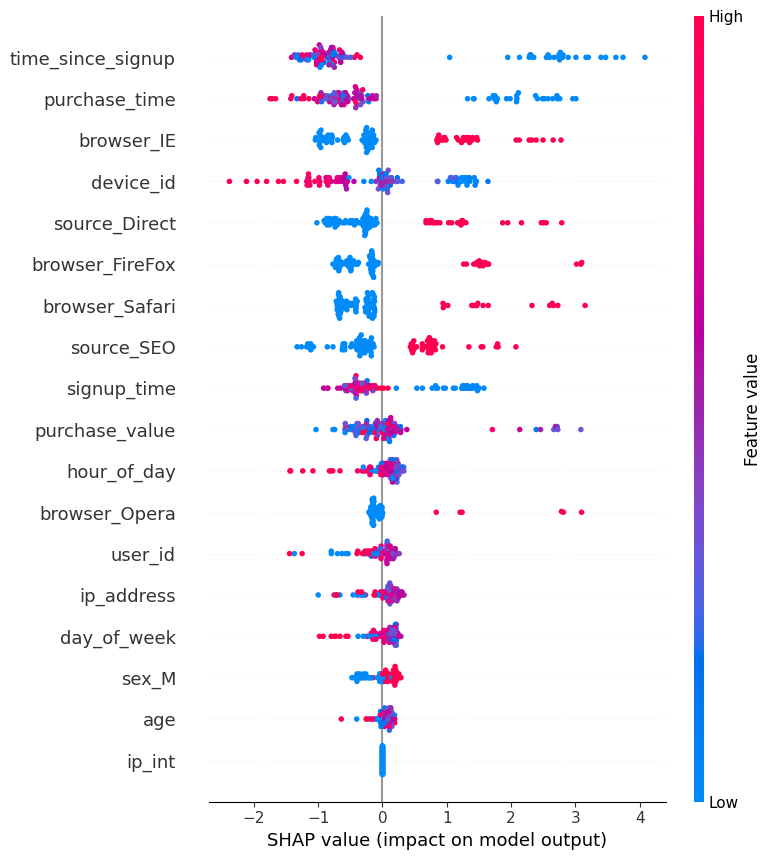

In [15]:
import shap
import pandas as pd

# Step 1: Copy
X_train_clean = X_train.copy()
X_test_clean = X_test.copy()

# Step 2: Encode categorical columns
for col in X_train_clean.select_dtypes(include=['object', 'category']).columns:
    X_train_clean[col], _ = pd.factorize(X_train_clean[col])
    X_test_clean[col], _ = pd.factorize(X_test_clean[col])

# Step 3: Ensure all data is numeric
X_train_clean = X_train_clean.apply(pd.to_numeric, errors='coerce')
X_test_clean = X_test_clean.apply(pd.to_numeric, errors='coerce')

# Step 4: Drop rows with NaNs (optional)
X_train_clean = X_train_clean.dropna()
X_test_clean = X_test_clean.dropna()

# ✅ Step 5: Enforce float64 dtype
X_train_clean = X_train_clean.astype('float64')
X_test_clean = X_test_clean.astype('float64')

# Step 6: Create SHAP explainer
explainer = shap.Explainer(model, X_train_clean)

# Step 7: Compute SHAP values
shap_values = explainer(X_test_clean[:100])

# Step 8: Plot summary
shap.summary_plot(shap_values, X_test_clean[:100])
